In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, StatsBase
using StatsPlots

using CSV, DataFrames, Muon, MAT

In [2]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"));

In [3]:
# Match BioBank measurements to column order of UniProt
bbmtx = zeros(size(biobank["oggs"].X, 1), length(uniprot.var_names.vals));
rawidxs = indexin(biobank["oggs"].var_names.vals, uniprot.var_names.vals)
bbmask = .!isnothing.(rawidxs)
uporderedmask = filter(x->.!isnothing(x), rawidxs);
bbmtx[:, uporderedmask] .= biobank["oggs"].X[:, :][:, bbmask];

In [4]:
UPusv = SVD(uniprot.obsm["LSVs"][:, :], uniprot.uns["SVs"][:], uniprot.varm["RSVs"][:, :]');

In [5]:
BBuhat = projectinLSV(bbmtx, UPusv);

## Make M' and M'' and calculate variable OGGs

In [6]:
r_idxs = occursin.("gnavus", biobank.obs.species) |> findall
popat!(r_idxs, occursin.("MSK.8.22", biobank.obs_names[r_idxs]) |> findfirst) # outlier sample
b_idxs = occursin.("uniformis", biobank.obs.species) |> findall;
# popat!(b_vulgatus_idxs, occursin.("MSK.7.24", biobank.obs_names[b_vulgatus_idxs]) |> findfirst) # contaminated sample
donorid = biobank.obs_names |>
    v -> split.(v, ".") |>
    v -> getindex.(v, 2) |>
    v -> parse.(Int,v)

b_idxs = b_idxs[sortperm(donorid[b_idxs])]
r_idxs = r_idxs[sortperm(donorid[r_idxs])]

idxs = union(b_idxs,  r_idxs);

In [7]:
oggisinbr = sum(bbmtx[idxs,:]; dims=1)[:] .> 0.;
oggisincsb = sum(bbmtx; dims=1)[:] .> 0.;

In [8]:
Mprime_early_br = BBuhat[idxs, 1:10] * diagm(UPusv.S[1:10]) * UPusv.Vt[1:10, oggisinbr];
Mprime_middle_br = BBuhat[idxs, 11:90] * diagm(UPusv.S[11:90]) * UPusv.Vt[11:90, oggisinbr];
Mprime_late_br = BBuhat[idxs, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, oggisinbr];

In [12]:
Mprime_early = BBuhat[:, 1:10] * diagm(UPusv.S[1:10]) * UPusv.Vt[1:10, oggisincsb];
Mprime_middle = BBuhat[:, 11:90] * diagm(UPusv.S[11:90]) * UPusv.Vt[11:90, oggisincsb];
Mprime_late = BBuhat[:, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, oggisincsb];

In [9]:
var_Mprime_early_br_all = findall(mapslices(var, Mprime_early_br, dims=1)[:].>1.);
var_Mprime_middle_br_all = findall(mapslices(var, Mprime_middle_br, dims=1)[:].>1.);
var_Mprime_late_br_all = findall(mapslices(var, Mprime_late_br, dims=1)[:].>1.);

In [13]:
var_Mprime_early_all = findall(mapslices(var, Mprime_early, dims=1)[:].>1.);
var_Mprime_middle_all = findall(mapslices(var, Mprime_middle, dims=1)[:].>1.);
var_Mprime_late_all = findall(mapslices(var, Mprime_late, dims=1)[:].>1.);

In [10]:
rdir = projectdir("_research", "GSEA") |> mkpath

"/Users/ben/projects/Doran_etal_2022/_research/GSEA"

### Write out variable OGGs in uniformis & gnavus

In [ ]:
uniprot.var[oggisinbr, :][setdiff(var_Mprime_late_br_all, var_Mprime_middle_br_all, var_Mprime_early_br_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_latewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/latewindow_GSEA/uniquevariable_latewindow_oggs.tsv"

In [40]:
uniprot.var[oggisinbr, :][setdiff(var_Mprime_middle_br_all, var_Mprime_early_br_all, var_Mprime_late_br_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_middlewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/latewindow_GSEA/uniquevariable_middlewindow_oggs.tsv"

In [41]:
uniprot.var[oggisinbr, :][setdiff(var_Mprime_early_br_all, var_Mprime_middle_br_all, var_Mprime_late_br_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_earlywindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/latewindow_GSEA/uniquevariable_earlywindow_oggs.tsv"

### write out variable OGGs for all CSB

In [15]:
uniprot.var[oggisincsb, :][setdiff(var_Mprime_late_all, var_Mprime_middle_all, var_Mprime_early_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_allCSB_latewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/GSEA/uniquevariable_allCSB_latewindow_oggs.tsv"

In [16]:
uniprot.var[oggisincsb, :][setdiff(var_Mprime_middle_all, var_Mprime_early_all, var_Mprime_late_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_allCSB_middlewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/GSEA/uniquevariable_allCSB_middlewindow_oggs.tsv"

In [17]:
uniprot.var[oggisincsb, :][setdiff(var_Mprime_early_all, var_Mprime_middle_all, var_Mprime_late_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_allCSB_earlywindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/GSEA/uniquevariable_allCSB_earlywindow_oggs.tsv"

## Venn Diagram

In [44]:
oggsincsb = mapslices(x->sum(x)>0., bbmtx, dims=1)[:];

In [45]:
Mprime_early = BBuhat[:, 1:10] * diagm(UPusv.S[1:10]) * UPusv.Vt[1:10, oggsincsb];
Mprime_middle = BBuhat[:, 11:90] * diagm(UPusv.S[11:90]) * UPusv.Vt[11:90, oggsincsb];
Mprime_late = BBuhat[:, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, oggsincsb];

In [61]:
var_Mprime_early_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_early, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_middle_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_middle, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_late_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_late, dims=1)[:], 1:100, rev=true), :og];
# var_Mprime_middle_all = findall(mapslices(var, Mprime_middle, dims=1)[:].>1.);
# var_Mprime_late_all = findall(mapslices(var, Mprime_late, dims=1)[:].>1.);

In [ ]:
var_Mprime_early_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_early, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_middle_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_middle, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_late_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_late, dims=1)[:], 1:100, rev=true), :og];
# var_Mprime_middle_all = findall(mapslices(var, Mprime_middle, dims=1)[:].>1.);
# var_Mprime_late_all = findall(mapslices(var, Mprime_late, dims=1)[:].>1.);

In [63]:
length.([
    setdiff(var_Mprime_early_all, var_Mprime_middle_all, var_Mprime_late_all),
    setdiff(var_Mprime_middle_all, var_Mprime_late_all, var_Mprime_early_all),
    setdiff(var_Mprime_late_all, var_Mprime_early_all, var_Mprime_middle_all),
])


3-element Vector{Int64}:
 26
 16
 51

In [68]:
length.([
    setdiff(intersect(var_Mprime_early_all, var_Mprime_middle_all), var_Mprime_late_all),
    setdiff(intersect(var_Mprime_middle_all, var_Mprime_late_all), var_Mprime_early_all),
    setdiff(intersect(var_Mprime_late_all, var_Mprime_early_all), var_Mprime_middle_all),
])

3-element Vector{Int64}:
 44
 19
  9

In [71]:
length.([
    intersect(var_Mprime_early_all, var_Mprime_middle_all),
    intersect(var_Mprime_middle_all, var_Mprime_late_all),
    intersect(var_Mprime_late_all, var_Mprime_early_all),
])

3-element Vector{Int64}:
 65
 40
 30

In [70]:
length(intersect(var_Mprime_early_all, var_Mprime_middle_all, var_Mprime_late_all))

21

In [74]:
var_Mprime_early_br_all = uniprot.var[oggisinbr, :][partialsortperm(mapslices(var, Mprime_early_br, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_middle_br_all = uniprot.var[oggisinbr, :][partialsortperm(mapslices(var, Mprime_middle_br, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_late_br_all = uniprot.var[oggisinbr, :][partialsortperm(mapslices(var, Mprime_late_br, dims=1)[:], 1:100, rev=true), :og];

In [75]:
length.([
    intersect(var_Mprime_early_br_all, var_Mprime_middle_br_all),
    intersect(var_Mprime_middle_br_all, var_Mprime_late_br_all),
    intersect(var_Mprime_late_br_all, var_Mprime_early_br_all),
])

3-element Vector{Int64}:
 54
 26
 26

In [77]:
length(intersect(var_Mprime_early_br_all, var_Mprime_middle_br_all, var_Mprime_late_br_all))

16

## GSEA wordcloud

In [20]:
using WordCloud

[ Info: Threads.nthreads() = 1


## Gnavus & Uniformis pathways

### Early window

In [19]:
earlywindowdf = CSV.read(joinpath(rdir, "davidresults","gnavus_uniformis","earlywindow-chart.tsv"), DataFrame; header=1, delim="\t");

In [24]:
ewdf = filter(:Benjamini => <(0.05), earlywindowdf);

In [25]:
ewdf |> names

13-element Vector{String}:
 "Category"
 "Term"
 "Count"
 "%"
 "PValue"
 "Genes"
 "List Total"
 "Pop Hits"
 "Pop Total"
 "Fold Enrichment"
 "Bonferroni"
 "Benjamini"
 "FDR"

In [56]:
processedwords_ew = ewdf.Term |>
    x->replace.(x, 
        r".*:"=>"", 
        r".*\~"=>"", 
        ","=>"", 
        "/"=>"",) |>
    x->lowercase.(x) |>
    x->join(x, " ") |>
    x->replace(x, 
        r" sm[0-9]{5}"=>s"",
        "amino acid"=>"amino-acid",
    ) |>
    x->split.(x, " ") 

200-element Vector{SubString{String}}:
 "alcohol"
 "dehydrogenase"
 "c-terminal"
 "groes-like"
 "alcohol"
 "dehydrogenase"
 "groes-like"
 "transcription"
 "regulator"
 "iclr"
 ⋮
 "repressor"
 "mechanosensitive"
 "ion"
 "channel"
 "mscs"
 "transmembrane-2"
 "beta-lactamasetranspeptidase-like"
 "ami_3"
 "hth_marr"

Total words: 193. Unique words: 92. After filtration: 88.
The top 88 words are kept. 
mask size: 400×600, content area: 488² (52²/word)
set fontsize ∈ [8.0, 400]
set density = 0.5


┌ Warning: editing svg file is not supported: () Base.Pairs(:color => :default, :backgroundcolor => :default)
└ @ WordCloud /Users/ben/.julia/packages/WordCloud/nwC7b/src/wc-helper.jl:67


⋯scale=58.144852425957396, density=0.44338817696735433	↓
⋯scale=61.74534485773425, density=0.5127288769379438	↑
fontsize ∈ [9.883988417583053, 74.53216847444895]


gathering style: rt = 1, ellipse
▸1. scale = 61.100303341918995


┌ Info: nepoch: 1000, patient: 10
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:482


┌ Info: @epoch 20(+3), 15(2) collisions, reposition [55] to [(642, 257)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 29(+6), 21(2) collisions, reposition [83] to [(456, 391)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494


48 epochs


┌ Info: @epoch 38(+7), 16(3) collisions, reposition [15] to [(502, 183)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494


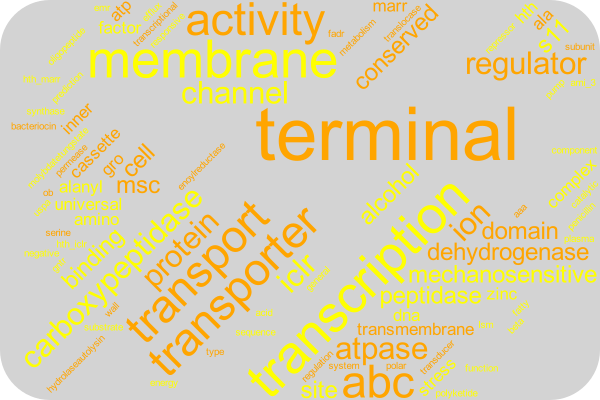

In [100]:
wc_ew = wordcloud(processedwords_ew;
    # masksize = (300, 200),
    mask=shape(box, 600, 400, cornerradius=50, color="lightgrey"),
    outline=1,
    colors=("yellow", "orange"),
    angles=[0, 45],
    fonts=("Arial"),
    )
generate!(wc_ew, optimiser=WordCloud.Momentum())
wc_ew

In [101]:
pdir = plotsdir("GSEA_wordclouds") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_wordclouds"

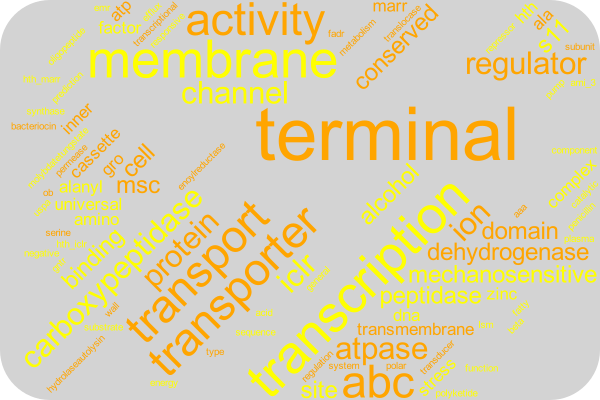

In [106]:
paint(wc_ew, joinpath(pdir, "earlywindow_gnavus-uniformis.svg"))

### middle window

In [107]:
middlewindowdf = CSV.read(joinpath(rdir, "davidresults","gnavus_uniformis","middlewindow-chart.tsv"), DataFrame; header=1, delim="\t");

In [111]:
mwdf = filter(:Benjamini => <(0.05), middlewindowdf);

In [112]:
mwdf |> names

13-element Vector{String}:
 "Category"
 "Term"
 "Count"
 "%"
 "PValue"
 "Genes"
 "List Total"
 "Pop Hits"
 "Pop Total"
 "Fold Enrichment"
 "Bonferroni"
 "Benjamini"
 "FDR"

In [113]:
processedwords_mw = mwdf.Term |>
    x->replace.(x, 
        r".*:"=>"", 
        r".*\~"=>"", 
        ","=>"", 
        "/"=>"",) |>
    x->lowercase.(x) |>
    x->join(x, " ") |>
    x->replace(x, 
        r" sm[0-9]{5}"=>s"",
        "amino acid"=>"amino-acid",
    ) |>
    x->split.(x, " ") 

165-element Vector{SubString{String}}:
 "transposition"
 "transposition"
 "amino-acidpolyamine"
 "transporter"
 "i"
 "hth-like"
 "domain"
 "integrase"
 "catalytic"
 "core"
 ⋮
 "activity"
 "proton"
 "symporter"
 "activity"
 "antiporter"
 "activity"
 "3-hydroxyacyl-coa"
 "dehydrogenase"
 "activity"

Total words: 163. Unique words: 75. After filtration: 67.
The top 67 words are kept. 
mask size: 400×600, content area: 488² (60²/word)
set fontsize ∈ [8.0, 400]
set density = 0.5
The word "dehydrogenase"(76.87942297863606) is too big. Set maxfontsize = 65.99503552874789.


┌ Warning: editing svg file is not supported: () Base.Pairs(:color => :default, :backgroundcolor => :default)
└ @ WordCloud /Users/ben/.julia/packages/WordCloud/nwC7b/src/wc-helper.jl:67


⋯scale=66.63696477651774, density=0.42700054619553807	↓
⋯scale=72.1084224196085, density=0.47230292844838456	↓


⋯scale=75.25788324800241, density=0.5145692617957229	↑
fontsize ∈ [9.886874744772157, 65.99503552874789]


┌ Warning: Some words are limited to the maximum font size. Please set a `maxfontsize` in `wordcloud` or set a `maxweight` in `processtext`.
└ @ WordCloud /Users/ben/.julia/packages/WordCloud/nwC7b/src/wc-method.jl:65


▸1. scale = 74.18736203231722
22 epochs


┌ Info: nepoch: 1000, patient: 10
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:482
┌ Info: @epoch 11(+3), 14(1) collisions, reposition [11] to [(415, 159)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 21(+2), 1(1) collisions, reposition [24] to [(457, 235)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494


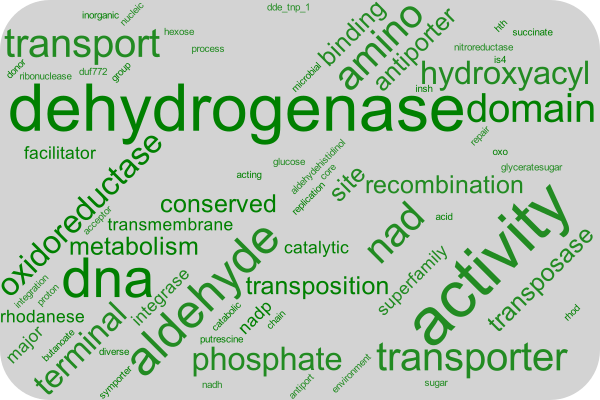

In [115]:
wc_mw = wordcloud(processedwords_mw;
    # masksize = (300, 200),
    mask=shape(box, 600, 400, cornerradius=50, color="lightgrey"),
    outline=1,
    colors=("forestgreen", "green"),
    angles=[0, 45],
    fonts=("Arial"),
    )
generate!(wc_mw, optimiser=WordCloud.Momentum())
wc_mw

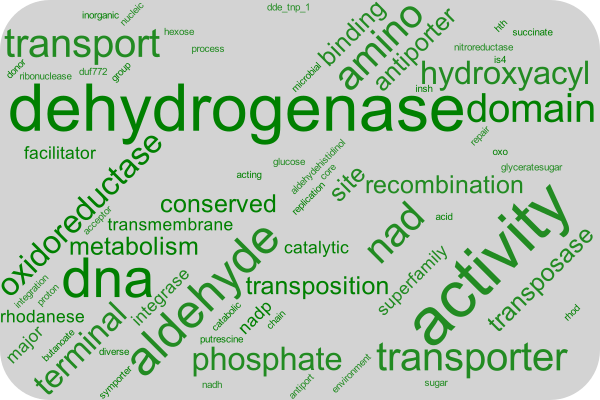

In [116]:
paint(wc_mw, joinpath(pdir, "middlewindow_gnavus-uniformis.svg"))

### late window

In [117]:
latewindowdf = CSV.read(joinpath(rdir, "davidresults","gnavus_uniformis","latewindow-chart.tsv"), DataFrame; header=1, delim="\t");

In [118]:
lwdf = filter(:Benjamini => <(0.05), latewindowdf);

In [119]:
lwdf |> names

13-element Vector{String}:
 "Category"
 "Term"
 "Count"
 "%"
 "PValue"
 "Genes"
 "List Total"
 "Pop Hits"
 "Pop Total"
 "Fold Enrichment"
 "Bonferroni"
 "Benjamini"
 "FDR"

In [ ]:
processtext()

In [121]:
processedwords_lw = lwdf.Term |>
    x->replace.(x, 
        r".*:"=>"", 
        r".*\~"=>"", 
        ","=>"", 
        "/"=>"",) |>
    x->lowercase.(x) |>
    x->join(x, " ") |>
    x->replace(x, 
        r" sm[0-9]{5}"=>s"",
        "amino acid"=>"amino-acid",
    ) |>
    x->split.(x, " ") |>
    x->processtext(x, stopwords=WordCloud.stopwords_en)

Total words: 181. Unique words: 101. After filtration: 97.
The top 97 words are kept. 


(["site", "domain", "carbohydrate", "nudix", "hydrolase", "kinase", "conserved", "terminal", "cell", "dihydrodipicolinate"  …  "xanthineuracil", "superfamily", "mera", "ribosomal", "box", "catabolic", "transition", "phenylacetic", "pathway", "type"], [0.04154802259887006, 0.04154802259887006, 0.035898305084745764, 0.035898305084745764, 0.035898305084745764, 0.030248587570621467, 0.030248587570621467, 0.030248587570621467, 0.024598870056497177, 0.024598870056497177  …  0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294, 0.007649717514124294])

mask size: 400×600, content area: 488² (50²/word)
set fontsize ∈ [8.0, 400]
set density = 0.5
⋯scale=55.381758506368605, density=0.4757297172387715	↓
⋯scale=56.776890406032244, density=0.4941843620015966	

┌ Warning: editing svg file is not supported: () Base.Pairs(:color => :default, :backgroundcolor => :default)
└ @ WordCloud /Users/ben/.julia/packages/WordCloud/nwC7b/src/wc-helper.jl:67


↓
fontsize ∈ [10.319193249977879, 56.04678519965828]


▸1. scale = 57.209490638280535


┌ Info: nepoch: 1000, patient: 10
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:482
┌ Info: @epoch 11(+2), 8(1) collisions, reposition [12] to [(398, 152)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494


33 epochs


┌ Info: [52] are out of bounds
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:421
┌ Info: @epoch 18(+6), 18(2) collisions, reposition [52] to [(523, 251)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 22(+2), 7(1) collisions, reposition nothing
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 23(+3), 9(1) collisions, reposition [86] to [(683, 379)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494
┌ Info: @epoch 30(+4), 2(1) collisions, reposition [44] to [(674, 754)]
└ @ Stuffing.Trainer /Users/ben/.julia/packages/Stuffing/oYQwL/src/fit.jl:494


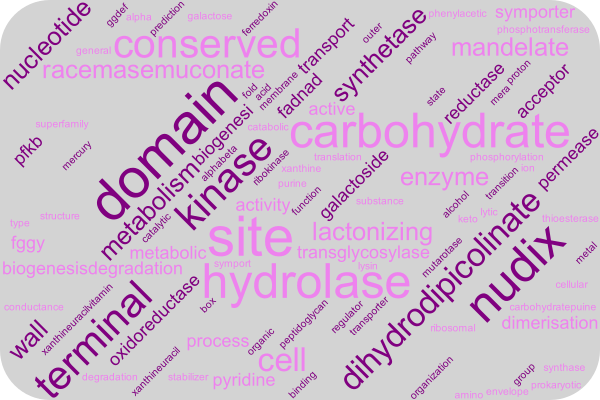

In [137]:
wc_lw = wordcloud(processedwords_lw;
    # masksize = (300, 200),
    mask=shape(box, 600, 400, cornerradius=50, color="lightgrey"),
    outline=1,
    colors=["violet", "purple"],
    angles=[0, 45],
    fonts=("Arial"),
    );
generate!(wc_lw, optimiser=WordCloud.Momentum());
wc_lw

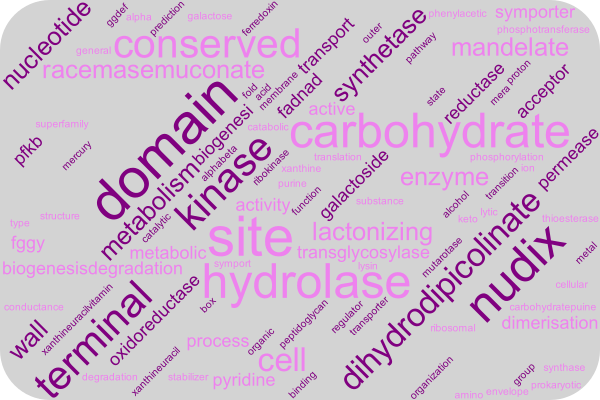

In [138]:
paint(wc_lw, joinpath(pdir, "latewindow_gnavus-uniformis.svg"))